<a href="https://colab.research.google.com/github/zhenghuazx/ICU-treatment-covid-19/blob/master/DDPG_ICU_oxygen_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [153]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,jaccard_score,mean_squared_error
import random


In [154]:
demo_predictor_col = ['LIVING_STAT', 'DEATH_DATE', 'age','BMI', 'hyperlipidemia', 'coronary_artery_disease',
       'heart_failure', 'hypertension', 'diabetes',
       'asthma_or_chronic_obstructive_pulmonary', 'dementia', 'stroke','SEX_Male', 'RACE_Asian', 'RACE_Multiple Race',
       'RACE_Native American (American Indian/Eskimo/Aleutian)',
       'RACE_Native Hawaiian or Other Pacific Islander', 'RACE_Other Race',
       'RACE_Patient_Refused', 'RACE_Unknown', 'RACE_White',
       'TOBACCO_USER_Not Asked', 'TOBACCO_USER_Passive', 'TOBACCO_USER_Quit',
       'TOBACCO_USER_Yes']
demo_state_col = ['age','BMI', 'hyperlipidemia', 'coronary_artery_disease',
       'heart_failure', 'hypertension', 'diabetes',
       'asthma_or_chronic_obstructive_pulmonary', 'dementia', 'stroke','SEX_Male', 'RACE_Asian', 'RACE_Multiple Race',
       'RACE_Native American (American Indian/Eskimo/Aleutian)',
       'RACE_Native Hawaiian or Other Pacific Islander', 'RACE_Other Race',
       'RACE_Patient_Refused', 'RACE_Unknown', 'RACE_White',
       'TOBACCO_USER_Not Asked', 'TOBACCO_USER_Passive', 'TOBACCO_USER_Quit',
       'TOBACCO_USER_Yes']
lab_state_col = ['ANION GAP','BASOPHILS %','BLOOD UREA NITROGEN','CALCIUM','CARBON DIOXIDE','CHLORIDE','CREATININE','EGFR MDRD AFRICAN AMERICAN','EGFR MDRD NON AFRICAN AMERICAN','EOSINOPHILS %','GLUCOSE','HCO3, ABG','HEMATOCRIT','HEMOGLOBIN',
                 'LYMPHOCYTES %','MAGNESIUM','MEAN CORPUSCULAR HEMOGLOBIN','MEAN PLATELET VOLUME','METHEMOGLOBIN, ABG','MONOCYTES %','NEUTROPHILS %','NUCLEATED RBC,ABSOLUTE','NUCLEATED RED BLOOD CELLS %',
                 'O2 CONTENT (SAT), ABG','OXYHEMOGLOBIN, ABG','PCO2, ABG','PH, ABG','PHOSPHORUS, INORGANIC','PLATELET COUNT','PO2, ABG','POTASSIUM','RDW-CV','RDW-SD','RED BLOOD CELL COUNT','SODIUM','WHITE BLOOD CELL COUNT']

ventilator_state_col = ['FiO2 %',
                        'Inspiratory Time (Sec)',
                        'Low Minute Volume (L/min)',
                        'PEEP (cmH2O)']
oxygen_action_col = ['oxygeen_rate']

bp_state_col = ['SBP']

temperature_state_col = ['temperature']

icu_key_index= ['PAT_ID', 'INPATIENT_DATA_ID', 'EPT_CSN', 'FSD_ID']

In [155]:
# demo = pd.read_csv('/content/inpatient_50.csv')
# lab = pd.read_csv('/content/ehr_labs_2020_top50test_wide.csv').drop('Unnamed: 0',axis=1)
# ventilator = pd.read_csv('/content/ventilator.csv')
# oxygen = pd.read_csv('/content/oxygen.csv')
# bp = pd.read_csv('/content/blood_pressure.csv')
# temperature = pd.read_csv('/content/temperature.csv')
result1 = pd.read_csv('/content/result.csv')

patients_set = set(result1['PAT_ID'].unique())
state_cols = demo_state_col + lab_state_col + ventilator_state_col + bp_state_col + temperature_state_col
reward_cols = ['reward']
target_column = ['oxygeen_rate']
state_size = len(state_cols)
action_size = 11
test_size=0.3

_temp = result1[state_cols].max(skipna=True) - result1[state_cols].min(skipna=True)
# _temp[result1[state_cols].columns[(_temp == 0).values]] = 1.0
normalized_df = (result1[state_cols] - result1[state_cols].min()) / _temp
normalized_df[reward_cols] = result1[reward_cols]
normalized_df[target_column] = result1[target_column]
normalized_df['PAT_ID'] = result1['PAT_ID']
normalized_df.fillna(normalized_df.mean(), inplace=True)
normalized_df['LIVING_STAT'] = (result1['LIVING_STAT'] == 'Deceased').astype(int)
normalized_df['outcome'] = result1['outcome']

# interested_train, interested_tests = train_test_split(normalized_df, test_size=test_size, random_state=11)
patients_set_val = random.choices(result1['PAT_ID'].unique(), k = int(len(patients_set) * 0.3))


In [430]:
interested_tests = normalized_df[normalized_df['PAT_ID'].isin(patients_set_val)]
patients_set_train = patients_set - set(patients_set_val)
interested_train = normalized_df[normalized_df['PAT_ID'].isin(patients_set_train)]

In [156]:
# test
val_prev_state = []
val_action = []
val_reward= []
val_state = []
val_mortality = []
count = {}
for patient in patients_set_val:
    minibatch_val = normalized_df[normalized_df['PAT_ID'] == patient]
    if minibatch_val.shape[0] < 2:
        continue
    next_state_val = minibatch_val[state_cols].iloc[1:,]
    prev_states_val, actions_val, rewards_val, states_val = np.array(minibatch_val[state_cols].iloc[:-1,]), np.array(minibatch_val[target_column])[:-1], np.array(minibatch_val[reward_cols])[1:], np.array(minibatch_val[state_cols].iloc[1:,])
    count[patient] = minibatch_val[state_cols].iloc[:-1,].shape[0]
    val_prev_state.append(prev_states_val)
    val_action.append(actions_val)#  np.vstack([val_actions,actions_val])
    val_reward.append(rewards_val) # = np.vstack([val_rewards,rewards_val])
    val_state.append(states_val) # = np.vstack([val_states,states_val])
    val_mortality.append(np.array(minibatch_val['LIVING_STAT'][1:]))
val_prev_states = np.concatenate(val_prev_state)
val_actions = np.concatenate(val_action)
val_rewards = np.concatenate(val_reward)
val_states = np.concatenate(val_state)
val_mortalityss = np.concatenate(val_mortality)


In [157]:
problem = "Feed-control-v0"
# env = fermentation_env(process_model)

num_states = len(state_cols) # env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = 1 # env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = 100.0 # upper bounad of agitation
lower_bound = 0.0 # upper bounad of agitation

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))


Size of State Space ->  65
Size of Action Space ->  1
Max Value of Action ->  100.0
Min Value of Action ->  0.0


In [158]:

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):

        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(tau):
    new_weights = []
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_critic.set_weights(new_weights)

    new_weights = []
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_actor.set_weights(new_weights)


def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.01, maxval=0.01)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(32, activation="relu")(inputs)
    out = layers.BatchNormalization()(out)
    # out = layers.Dense(128, activation="relu")(out)
    # out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.BatchNormalization()(state_out)
    # state_out = layers.Dense(32, activation="relu")(state_out)
    # state_out = layers.BatchNormalization()(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    # action_out = layers.Dense(32, activation="relu")(action_input)
    # action_out = layers.BatchNormalization()(action_out)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_input])

    out = layers.Dense(64, activation="relu")(concat)
    out = layers.BatchNormalization()(out)
    # out = layers.Dense(128, activation="relu")(out)
    # out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model


def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

std_dev = 0.005
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.001
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
# Discount factor for future rewards
gamma = 1.0
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)


# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

total_episodes = 4001



Streaming output truncated to the last 5000 lines.
rmse 1659.6283997286762
Episode * 2335 * Avg Reward is ==> -0.375
target_q_values 2435.104
rmse 1642.6024326777435
Episode * 2336 * Avg Reward is ==> 0.375
target_q_values 2439.9136
rmse 1564.3776147592703
Episode * 2337 * Avg Reward is ==> 0.75
target_q_values 2440.4548
rmse 1522.4887887194427
Episode * 2338 * Avg Reward is ==> 0.375
target_q_values 2442.1174
rmse 1623.1113388129777
Episode * 2339 * Avg Reward is ==> 0.75
target_q_values 2442.4097
rmse 1612.0012862152196
Episode * 2340 * Avg Reward is ==> 0.375
target_q_values 2443.705
rmse 1671.9244401809092
Episode * 2341 * Avg Reward is ==> 0.0
target_q_values 2443.7192
rmse 1660.5158096391417
Episode * 2342 * Avg Reward is ==> -0.375
target_q_values 2443.9988
rmse 1647.7645624822085
Episode * 2343 * Avg Reward is ==> -0.75
target_q_values 2444.0881
rmse 1661.270347761793
Episode * 2344 * Avg Reward is ==> -1.125
target_q_values 2445.202
rmse 1635.3234574251
Episode * 2345 * Avg Re

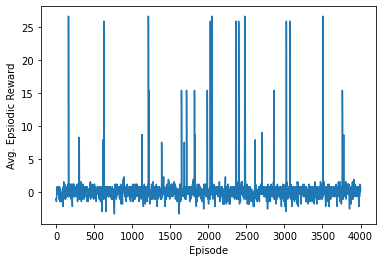

In [159]:
jac = []
qv = []
# Takes about 20 min to train
for e in range(total_episodes):
    episodic_reward = 0
    patient = random.sample(patients_set_train, 1)[0]
    minibatch = interested_train[interested_train['PAT_ID'] == patient]
    while minibatch.shape[0] < 2:
        patient = random.sample(patients_set_train, 1)[0]
        minibatch = interested_train[interested_train['PAT_ID'] == patient]
    next_state = minibatch[state_cols].iloc[1:,]
    prev_states, actions, rewards, states = np.array(minibatch[state_cols].iloc[:-1,]), np.array(minibatch[target_column]).flatten()[:-1], np.array(minibatch[reward_cols]).flatten()[1:], np.array(next_state)
#     print('---------1---------')
    for i in range(minibatch.shape[0]-1):
        buffer.record((prev_states[i], actions[i], rewards[i], states[i]))
        episodic_reward += rewards[i]
        buffer.learn()
        update_target(tau)
        ep_reward_list.append(episodic_reward)
#     print('---------2---------')
    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(e, avg_reward))
    avg_reward_list.append(avg_reward)
#     print('---------3---------')
    if e % 1 == 0:
        state_batch = tf.convert_to_tensor(val_prev_states)
        action_batch = tf.convert_to_tensor(val_actions)
        reward_batch = tf.convert_to_tensor(val_rewards)
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(val_states)

        preds = actor_model.predict(state_batch) # actor.model.predict([val_df[lab_test].values, val_df_di, val_sta])
        target_q_values = target_critic.predict([state_batch, preds])
        q = np.mean(target_q_values)
        print('target_q_values',q)
#         preds[preds >= 0.5] = 1
#         preds[preds < 0.5] = 0
#         j = jaccard_score(val_actions.flatten(), preds)
        j = mean_squared_error(val_actions.flatten(), preds)
        print('rmse',j )
        jac.append(j)
        qv.append(q)
        # print(qv)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

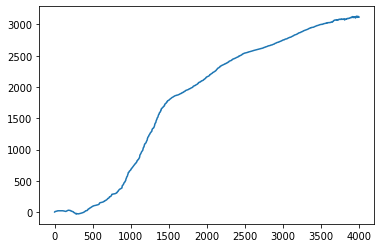

In [160]:
plt.figure(figsize=(6, 4.5))
plt.plot(bin_medians, sliding_mean(mort))
plt.fill_between(bin_medians, sliding_mean(mort) - 1*sliding_mean(mort_std),  
                 sliding_mean(mort) + 1*sliding_mean(mort_std), color='#ADD8E6')
plt.grid()
# plt.xticks(range(-15,20,5))
r = [float(i)/10 for i in range(0,11,1)]
_ = plt.yticks(r)
_ = plt.title("Mortality vs Expected Return", fontsize=15)  
_ = plt.ylabel("Proportion Mortality")
_ = plt.xlabel("Expected Return")
# plt.plot(qv)

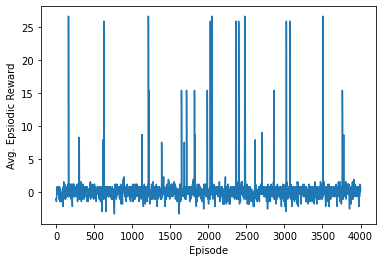

In [161]:
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [162]:
# val_prev_state = []
# val_action = []
# val_reward= []
# val_state = []
# val_mortality = []

physician_performance = []
phys_actions = []
for traj_id in range(len(val_prev_state)):
    q_vals = []
    state_batch = tf.convert_to_tensor(val_prev_state[traj_id])
    action_batch = tf.convert_to_tensor(val_action[traj_id])
    q_vals = target_critic.predict([state_batch, action_batch])
    physician_performance.append(list(q_vals.flatten()))
    # for row in range(trajectory.shape[0]):
    #     action = int(trajectory['oxygeen_rate'].iloc[row])
    #     #vaso = int(trajectory.ix[row, 'max_dose_vaso'])
    #     #action = action_map[iv,vaso]
    #     state = trajectory[state_cols].iloc[row]
    #     # state = tf.convert_to_tensor(np.array(state))
    #     # action = tf.convert_to_tensor(np.array(action))
    #     tgt_q_values = target_critic.predict([np.array(state).reshape(-1, len(state_cols)), np.array(action).reshape(-1, 1)])
    #     q_vals.append(tgt_q_values.flatten()[0])
    #     phys_actions.append(action)
    # physician_performance.append(q_vals)

In [123]:
len(physician_performance)

172

In [163]:
phys_score = 0.0
for arr in physician_performance:
    phys_score += np.mean(arr)
phys_score /= len(physician_performance)
print(phys_score)

3023.8287637804183


In [260]:
doctor_action = [i for i in val_actions.flatten() if i <=100] + [100]
state_batch = tf.convert_to_tensor(val_prev_states)
preds = actor_model.predict(state_batch)
RL_action = preds.flatten()


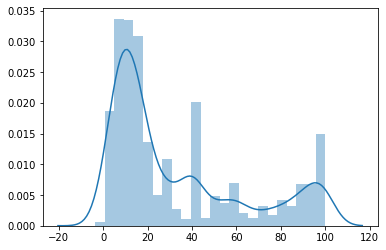

In [262]:
import seaborn as sns
sns.distplot(pd.DataFrame({'RL': RL_action, 'Doctors': doctor_action}), )

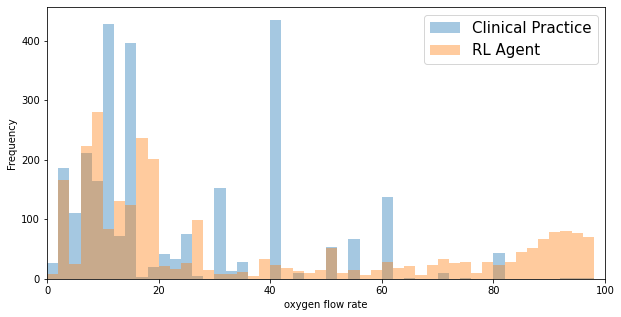

In [287]:
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(2):
    sns.distplot([doctor_action, RL_action][i], bins=range(0, 100, 2), ax=ax, label=['Clinical Practice','RL Agent'][i], kde=False)
ax.set_xlim([0, 100])
ax.set_xlabel('oxygen flow rate')
ax.set_ylabel('Frequency')
ax.legend(fontsize=15)
plt.savefig('/content/RL-vs-Clinician.png')

In [165]:
all_phys_performance = []
for arr in physician_performance:
    all_phys_performance.extend(arr)

pp = pd.Series(all_phys_performance)
phys_df = pd.DataFrame(pp)

In [166]:
phys_df

,0
0,5150.489746
1,5145.358887
2,5145.358887
3,4788.779297
4,4796.595215
...,...
2824,2214.751221
2825,2214.751221
2826,3846.568359
2827,3843.608887


In [167]:
import copy
phys_df['mort'] = val_mortalityss # copy.deepcopy(np.array(interested_tests['mortality']))

In [171]:
(5699 + 3428) / 20

456.35

In [577]:
from scipy.stats import sem
bin_medians = []

mort = []
mort_std = []
i = -3428
while i <= 4000:
    count =phys_df.loc[(phys_df[0]>i) & (phys_df[0]<i+500)]
    try:
        res = sum(count['mort'])/float(len(count))
        if len(count) >=2:
            bin_medians.append(i)
            mort.append(res)
            mort_std.append(sem(count['mort']))
    except ZeroDivisionError:
        pass
    i += 500

In [578]:
def sliding_mean(data_array, window=2):
    new_list = []
    for i in range(len(data_array)):
        indices = range(max(i - window + 1, 0),
                        min(i + window + 1, len(data_array)))
        avg = 0
        for j in indices:
            avg += data_array[j]
        avg /= float(len(indices))
        new_list.append(avg)     
    return np.array(new_list)

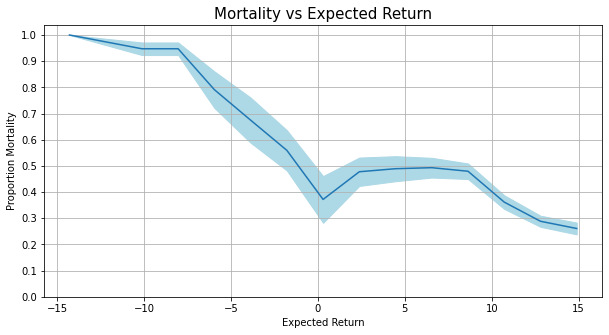

In [579]:
bin_medians = [i/ 240 for i in bin_medians ]
plt.figure(figsize=(10, 5))
plt.plot( bin_medians, sliding_mean(mort))
plt.fill_between(bin_medians, sliding_mean(mort) - 1*sliding_mean(mort_std),  
                 sliding_mean(mort) + 1*sliding_mean(mort_std), color='#ADD8E6')
plt.grid()
# plt.xticks(range(-15,20,5))
r = [float(i)/10 for i in range(0,11,1)]
_ = plt.yticks(r)
_ = plt.title("Mortality vs Expected Return", fontsize=15)  
_ = plt.ylabel("Proportion Mortality")
_ = plt.xlabel("Expected Return")

plt.savefig('/content/mortality-expected_return.png')

In [229]:
len(phys_df[phys_df['mort']==1])/float(len(phys_df))


0.335807705903146

In [371]:
interested_tests[['PAT_ID','LIVING_STAT']].drop_duplicates().mean()

LIVING_STAT    0.638554
dtype: float64

In [536]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score


seed = 7
test_size = 0.3
X_trian = interested_train[state_cols + oxygen_action_col]
X_trian['oxygeen_rate'] = X_trian['oxygeen_rate'] / (result1['oxygeen_rate'].max(skipna=True) - result1['oxygeen_rate'].min(skipna=True))
y_train = interested_train['LIVING_STAT']

X_test = interested_tests[state_cols + oxygen_action_col]
X_test['oxygeen_rate'] = X_test['oxygeen_rate'] / (result1['oxygeen_rate'].max(skipna=True) - result1['oxygeen_rate'].min(skipna=True))
y_test = interested_tests['LIVING_STAT']

model = xgb.XGBClassifier(learning_rate = 0.1,
                      n_estimators=35,
                      max_depth=4,
                      min_child_weight=1,
                      gamma=0,
                      subsample=0.8,
                      metrics=('error', 'auc'),
                      colsample_bytree=0.6,
                      objective= 'binary:logistic',
                      nthread=4,
                      verbosity=1,
                      scale_pos_weight=1,
                      seed=27)
train_model = model.fit(X_trian, y_train)
pred = train_model.predict(X_test)
print(classification_report(y_test, pred))
print('roc_auc_score: {}'.format(roc_auc_score(y_test, pred)))
print('mortality rate')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1590
           1       0.77      0.74      0.75       990

    accuracy                           0.81      2580
   macro avg       0.80      0.80      0.80      2580
weighted avg       0.81      0.81      0.81      2580

roc_auc_score: 0.7993805984372022
mortality rate


In [537]:
state_batch = tf.convert_to_tensor(val_prev_states)
action_batch = tf.convert_to_tensor(val_actions)
actions = actor_model.predict(state_batch)
all_data_RL = np.hstack((val_prev_states, actions / (result1['oxygeen_rate'].max(skipna=True) - result1['oxygeen_rate'].min(skipna=True))))
all_data_real = np.hstack((val_prev_states, val_actions/ (result1['oxygeen_rate'].max(skipna=True) - result1['oxygeen_rate'].min(skipna=True))))

In [538]:
all_data_RL = pd.DataFrame(all_data_RL, columns=X_trian.columns)
all_data_CP = pd.DataFrame(all_data_real, columns=X_trian.columns)
pred_RL = train_model.predict(all_data_RL)
pred_CP = train_model.predict(all_data_CP)

In [539]:
count = 0
mortality_pred_RL = []
mortality_real = []
for i in val_state:
  mortality_pred_RL.append(np.mean(pred_RL[count:count+len(i)]))
  mortality_real.append(val_mortalityss[count:count+len(i)].mean())
  count += len(i)

print(np.mean(mortality_pred_RL), np.mean(mortality_real))

0.49019095321052886 0.5828220858895705


In [540]:
group = [ 'hyperlipidemia', 'coronary_artery_disease',
       'heart_failure', 'hypertension', 'diabetes',
       'asthma_or_chronic_obstructive_pulmonary', 'dementia', 'stroke','SEX_Male', 'RACE_Asian', 'RACE_Multiple Race',
       'RACE_Native American (American Indian/Eskimo/Aleutian)',
       'RACE_Native Hawaiian or Other Pacific Islander', 'RACE_Other Race',
       'RACE_Patient_Refused', 'RACE_Unknown', 'RACE_White',
       'TOBACCO_USER_Not Asked', 'TOBACCO_USER_Passive', 'TOBACCO_USER_Quit',
       'TOBACCO_USER_Yes']

result_subgroup = []

for g in group:
  mortality_pred_RL = []
  mortality_real = []
  count = 0
  for i in val_state:
    if all_data_RL.iloc[count][g] == 1:
      mortality_pred_RL.append(np.mean(pred_RL[count:count+len(i)]))
      mortality_real.append(val_mortalityss[count:count+len(i)].mean())
    # mortality_pred_CP.append(np.mean(pred_CP[count:count+len(i)]))
    count += len(i)
  result_subgroup.append([np.mean(mortality_pred_RL), np.mean(mortality_real)])



/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [560]:
# Female
mortality_pred_RL = []
mortality_real = []
count = 0
for i in val_state:
  if all_data_RL.iloc[count]['SEX_Male'] == 0:
    mortality_pred_RL.append(np.mean(pred_RL[count:count+len(i)]))
    mortality_real.append(val_mortalityss[count:count+len(i)].mean())
  # mortality_pred_CP.append(np.mean(pred_CP[count:count+len(i)]))
  count += len(i)
print(np.mean(mortality_pred_RL), np.mean(mortality_real))
result_subgroup.append([np.mean(mortality_pred_RL), np.mean(mortality_real)])

0.4936675118718405 0.58


In [547]:
all_data_RL['age']

0       0.111345
1       0.111345
2       0.111345
3       0.111345
4       0.111345
          ...   
2824    0.194149
2825    0.194149
2826    0.352229
2827    0.352229
2828    0.597913
Name: age, Length: 2829, dtype: float64

In [564]:
# age
mortality_pred_RL = []
mortality_real = []
count = 0
age_group = ['50 to 65', '65 to 75', '75 to 80', '>80']
for i in val_state:
  range_age = (result1['age'].max(skipna=True) - result1['age'].min(skipna=True))
  min_age =result1['age'].min(skipna=True)
  _age = all_data_RL.iloc[count]['age'] *range_age +  min_age
  if _age >= 80 :
    mortality_pred_RL.append(np.mean(pred_RL[count:count+len(i)]))
    mortality_real.append(val_mortalityss[count:count+len(i)].mean())
  # mortality_pred_CP.append(np.mean(pred_CP[count:count+len(i)]))
  count += len(i)
print(np.mean(mortality_pred_RL), np.mean(mortality_real))
result_subgroup.append([np.mean(mortality_pred_RL), np.mean(mortality_real)])

0.6965692259809907 0.7777777777777778


In [573]:
# BMI
BMI_group = ['<25', '25.0-29.9', '30.0-39.9','>40']
mortality_pred_RL = []
mortality_real = []
count = 0
for i in val_state:
  range_bmi = (result1['BMI'].max(skipna=True) - result1['BMI'].min(skipna=True))
  min_bmi =result1['BMI'].min(skipna=True)
  _bmi = all_data_RL.iloc[count]['BMI'] *range_bmi +  min_bmi
  if _bmi < 39.9 and _bmi >= 40:
    mortality_pred_RL.append(np.mean(pred_RL[count:count+len(i)]))
    mortality_real.append(val_mortalityss[count:count+len(i)].mean())
  # mortality_pred_CP.append(np.mean(pred_CP[count:count+len(i)]))
  count += len(i)
print(np.mean(mortality_pred_RL), np.mean(mortality_real))
result_subgroup.append([np.mean(mortality_pred_RL), np.mean(mortality_real)])

0.5423280423280423 0.6666666666666666


In [575]:
# Smoking nevere
mortality_pred_RL = []
mortality_real = []
count = 0
Smoking = ['TOBACCO_USER_Not Asked', 'TOBACCO_USER_Passive', 'TOBACCO_USER_Quit',
       'TOBACCO_USER_Yes']
for i in val_state:
  if all_data_RL.iloc[count][Smoking].sum() == 0:
    mortality_pred_RL.append(np.mean(pred_RL[count:count+len(i)]))
    mortality_real.append(val_mortalityss[count:count+len(i)].mean())
  # mortality_pred_CP.append(np.mean(pred_CP[count:count+len(i)]))
  count += len(i)
print(np.mean(mortality_pred_RL), np.mean(mortality_real))
result_subgroup.append([np.mean(mortality_pred_RL), np.mean(mortality_real)])

0.4428258501674625 0.4864864864864865


In [576]:
# african
mortality_pred_RL = []
mortality_real = []
count = 0
Race = ['RACE_Asian', 'RACE_Multiple Race',
       'RACE_Native American (American Indian/Eskimo/Aleutian)',
       'RACE_Native Hawaiian or Other Pacific Islander', 'RACE_Other Race',
       'RACE_Patient_Refused', 'RACE_Unknown', 'RACE_White']
for i in val_state:
  if all_data_RL.iloc[count][Race].sum() == 0:
    mortality_pred_RL.append(np.mean(pred_RL[count:count+len(i)]))
    mortality_real.append(val_mortalityss[count:count+len(i)].mean())
  # mortality_pred_CP.append(np.mean(pred_CP[count:count+len(i)]))
  count += len(i)
print(np.mean(mortality_pred_RL), np.mean(mortality_real))
result_subgroup.append([np.mean(mortality_pred_RL), np.mean(mortality_real)])

0.6532040756178686 0.6111111111111112


In [574]:
pd.DataFrame(result_subgroup, columns=['RL Agent', 'Clinical Practice'],index=group +['Female']+ age_group+ BMI_group + ['Never Smoking'] + ['African American']).to_csv('/content/comparison.csv', index=True)